# Model Evaluation Notebook

This notebook evaluates the performance of the trained transformer model against baseline methods.

## Setup and Data Loading

In [ ]:
import sys
sys.path.append("..")

from core.DataLoader import DataPreprocessor, get_load_config_from_yaml
import numpy as np
from importlib import reload
import matplotlib.pyplot as plt
import yaml
import core.assignment_models as Models
import core
import os

# Configuration
PLOTS_DIR = "plots/assignment_transformer_high_level_features/"
MODEL_DIR = "models/assignment_transformer_high_level_features"
CONFIG_PATH = "../config/workspace_config_high_level_features.yaml"

# Create directories
os.makedirs(PLOTS_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

# Set plotting style
plt.rcParams.update({"font.size": 14})

# Load data
load_config = get_load_config_from_yaml(CONFIG_PATH)
DataProcessor = DataPreprocessor(load_config)

with open(CONFIG_PATH, "r") as file:
    data_configs = yaml.safe_load(file)

data_config = DataProcessor.load_from_npz(
    data_configs["data_path"]["nominal"], 
    max_events=10000000
)
X_train, y_train, X_val, y_val = DataProcessor.split_data(test_size=0.5)
del DataProcessor

print(f"Loaded {len(X_train['jet'])} training events and {len(X_val['jet'])} validation events")

## Load Model and Setup Evaluator

In [ ]:
reload(Models)
reload(core)
TransformerMatcher = Models.FeatureConcatTransformer(data_config, name=r"Transformer + $\nu^2$-Flows")

FeatureConcatTransformer is designed for classification tasks; regression targets will be ignored.
Building model without regression output.


In [ ]:
TransformerMatcher.load_model(f"{MODEL_DIR}/model.keras")

Model loaded from models/assignment_transformer_high_level_features/model.keras
Training history loaded from models/assignment_transformer_high_level_features/model_history.npz


In [ ]:
import core.reconstruction.BaselineMethods as BaselineMethods
import core.evaluation as Evaluation
from core.reconstruction import GroundTruthReconstructor

reload(Evaluation)
reload(BaselineMethods)
delta_r_assigner = BaselineMethods.DeltaRAssigner(
    data_config,
    use_nu_flows=True,
)
chi_square = BaselineMethods.ChiSquareAssigner(
    data_config,
    use_nu_flows=True,
    use_nu_flows_for_assignment=True,
    top_mass=173.5e3,
)


ground_truth_assigner = GroundTruthReconstructor(
    data_config, name=r"True Assignment + $\nu^2$-Flows", use_nu_flows=True
)
evaluator = Evaluation.ReconstructionEvaluator(
    [
        delta_r_assigner,
        #chi_square_true_nu,
        chi_square,
        TransformerMatcher,
        ground_truth_assigner,
    ],
    X_val,
    y_val,
)

/Users/simi/mva-trainer/notebooks/../core/reconstruction/BaselineMethods.py:346: RuntimeWarning: invalid value encountered in subtract
  mass_squared = e**2 - (px**2 + py**2 + pz**2)


## Distribution Plots

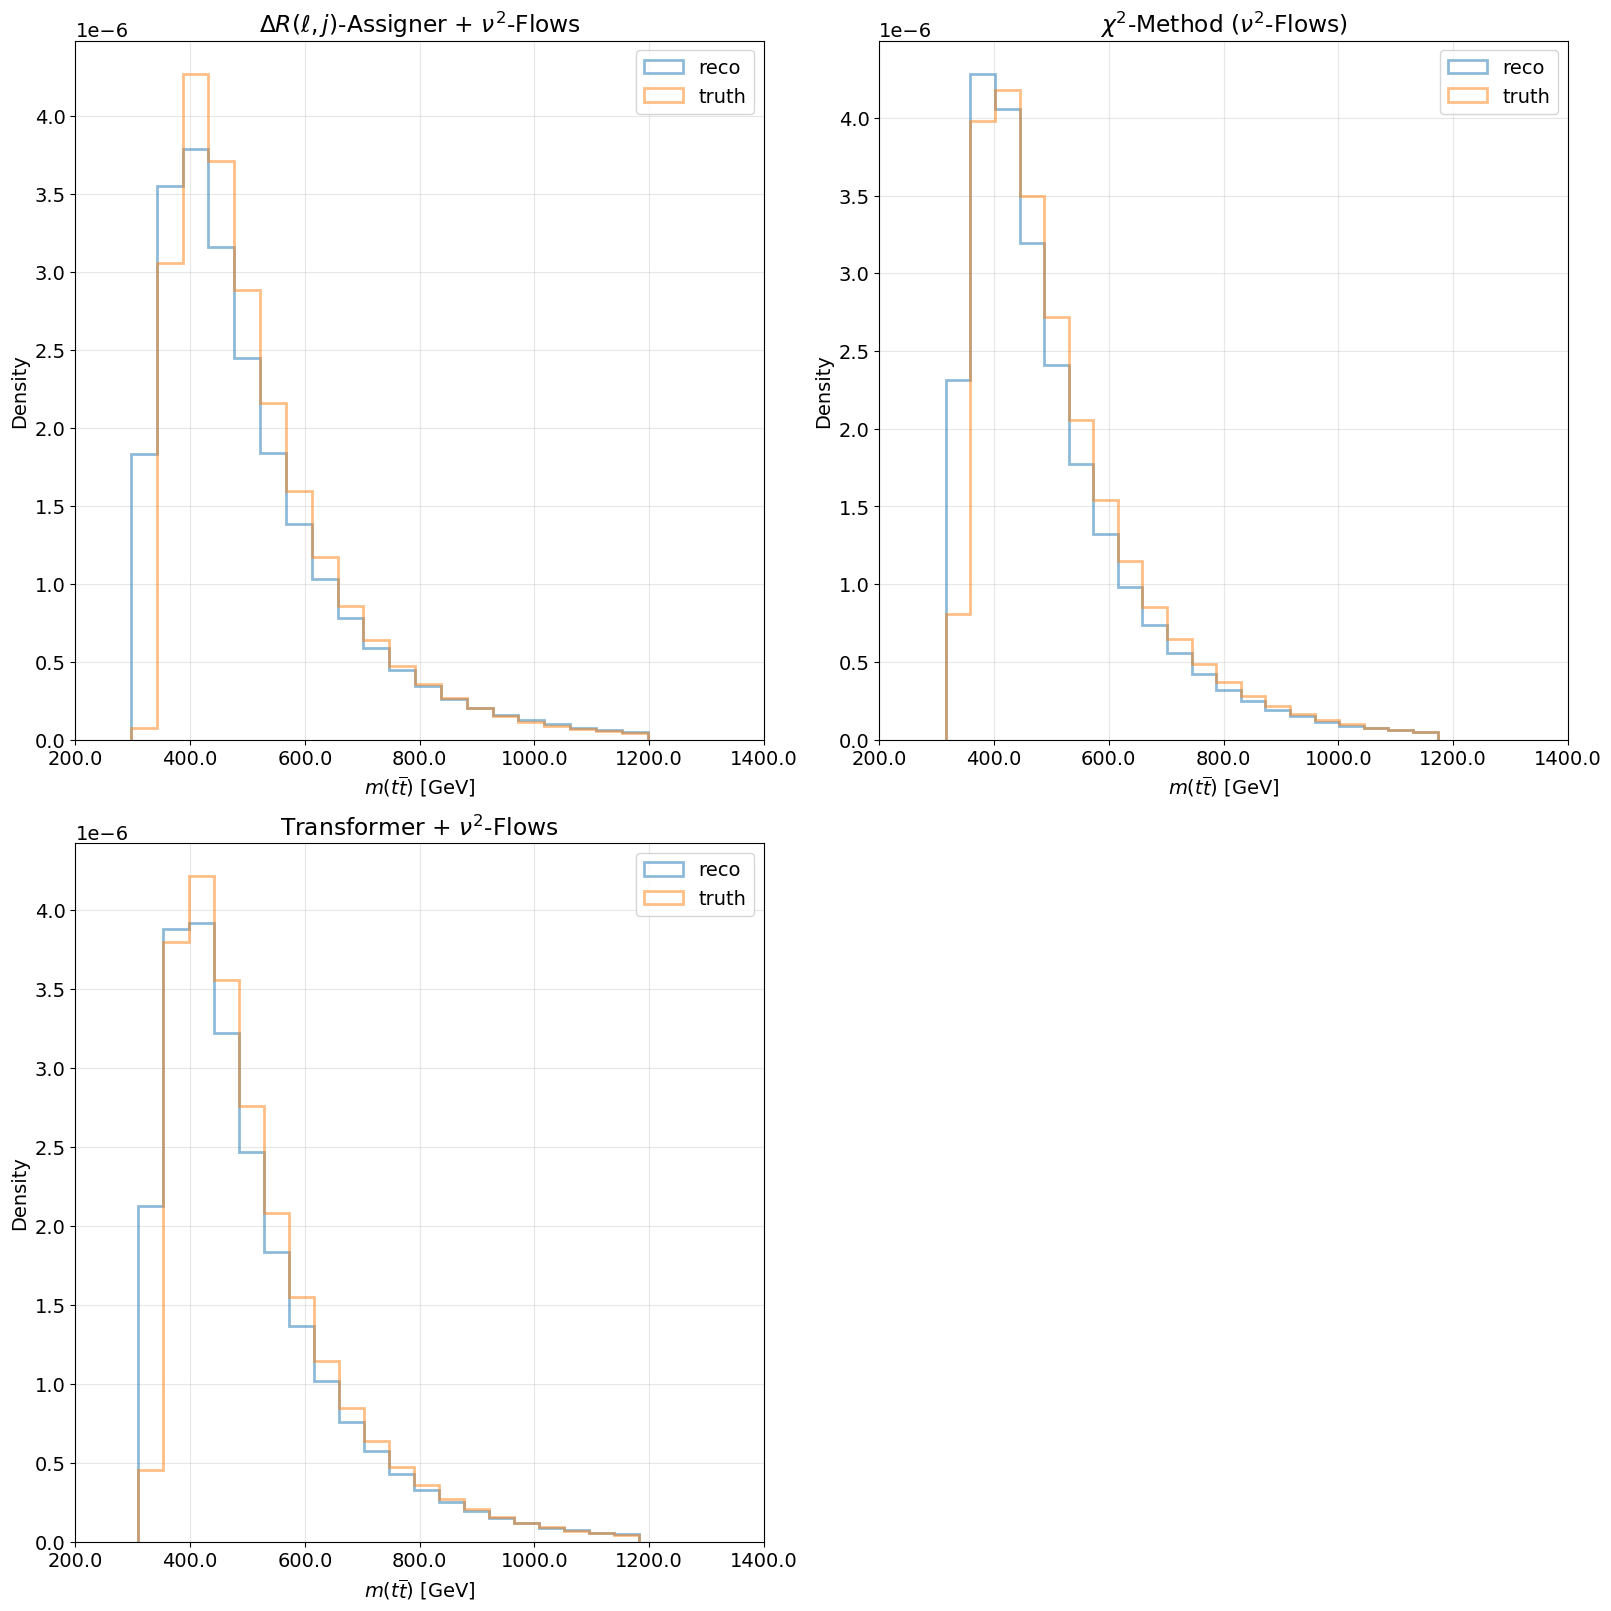

In [ ]:
fig, ax = evaluator.plot_ttbar_mass_distributions(bins = 20, figsize=(16,16))
fig.savefig(f"{PLOTS_DIR}/ttbar_mass_distributions.png", bbox_inches="tight")

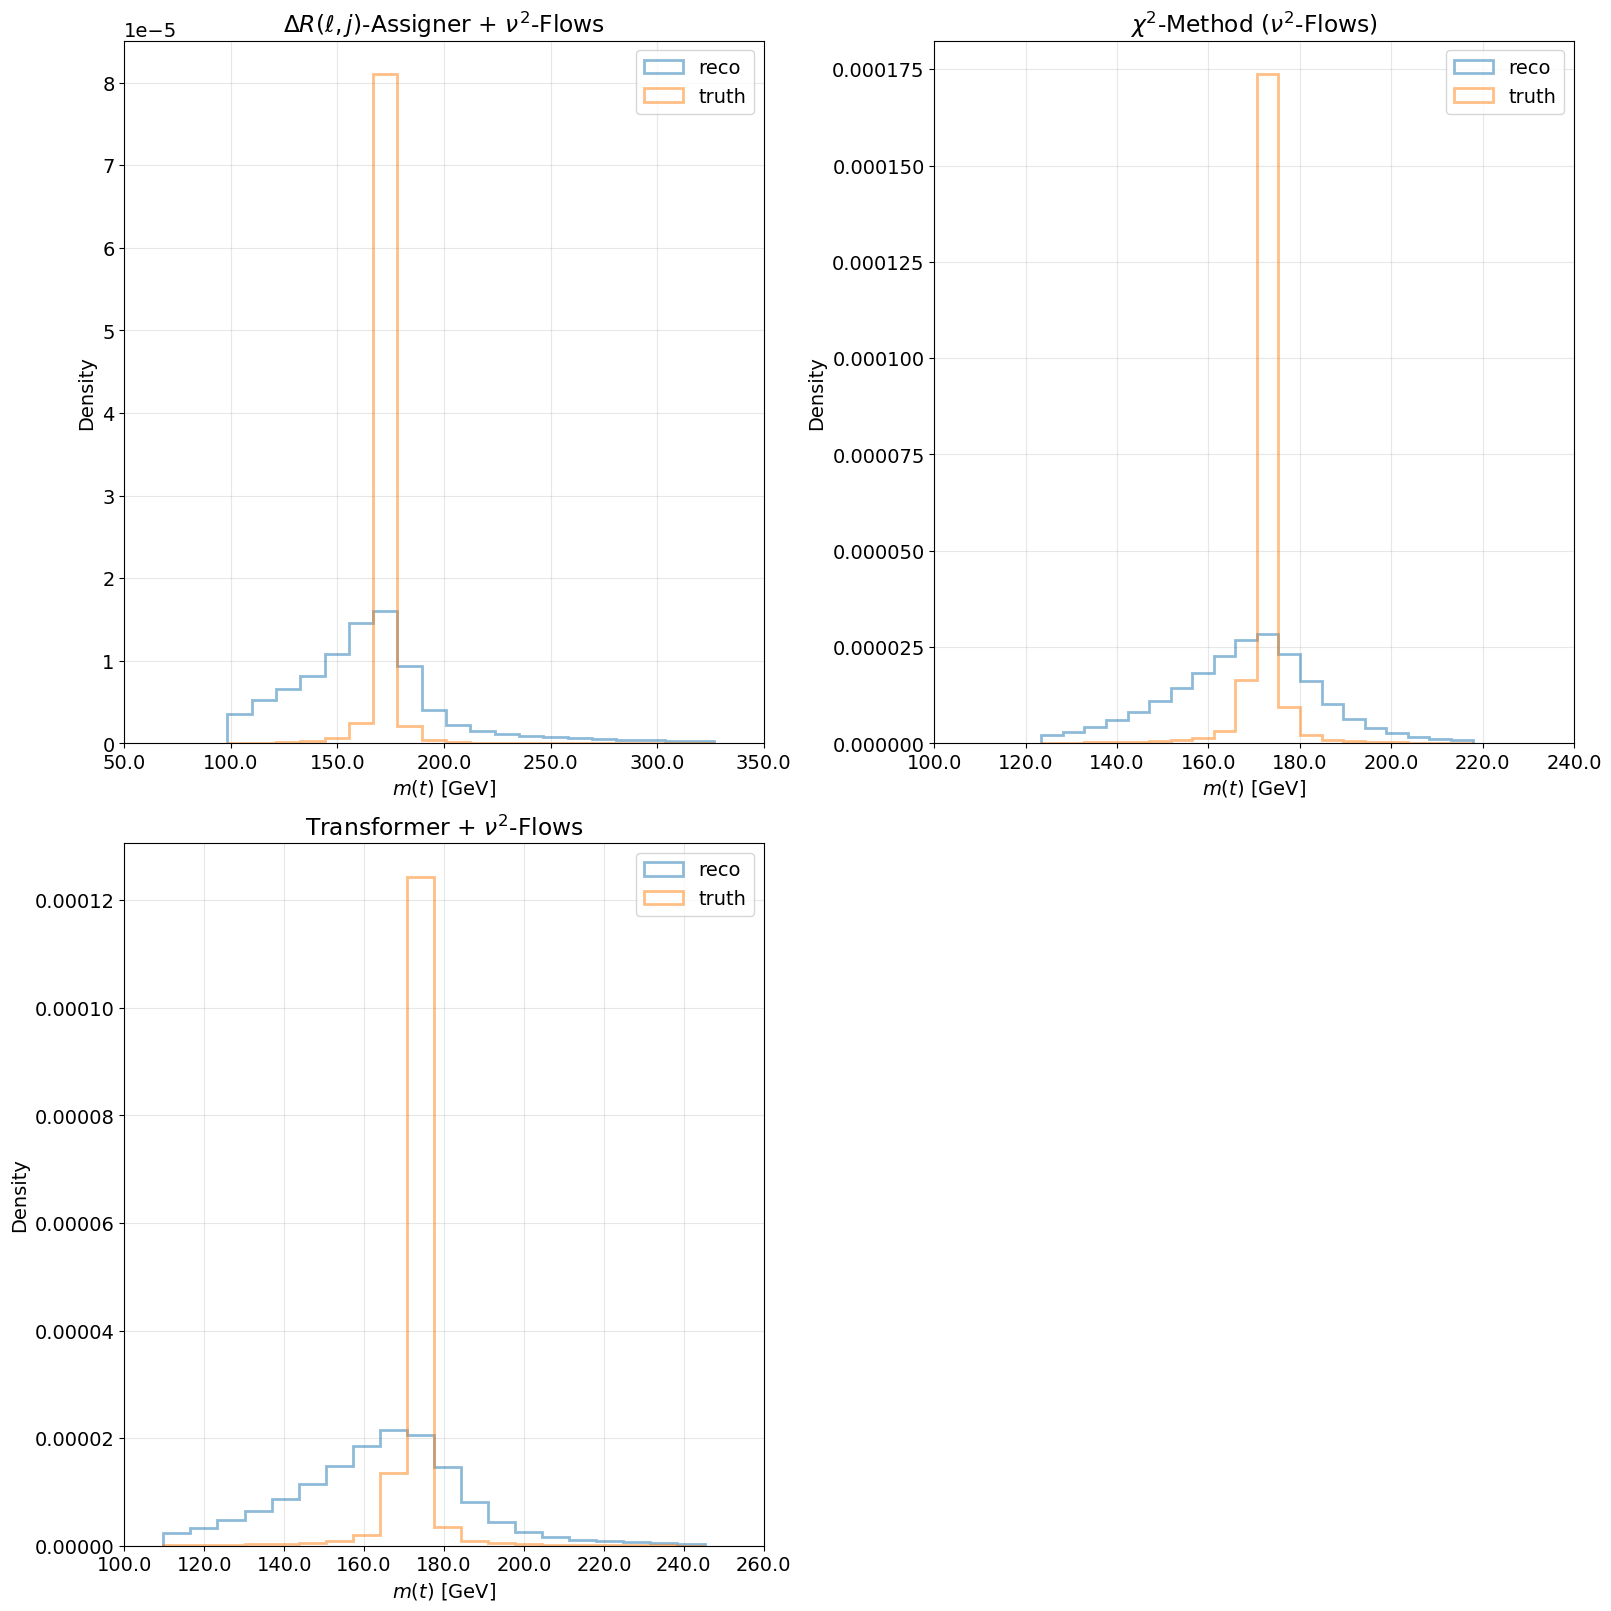

In [ ]:
fig, ax = evaluator.plot_top_mass_distributions(bins = 20, figsize=(16,16))
fig.savefig(f"{PLOTS_DIR}/top_mass_distributions.png", bbox_inches="tight")

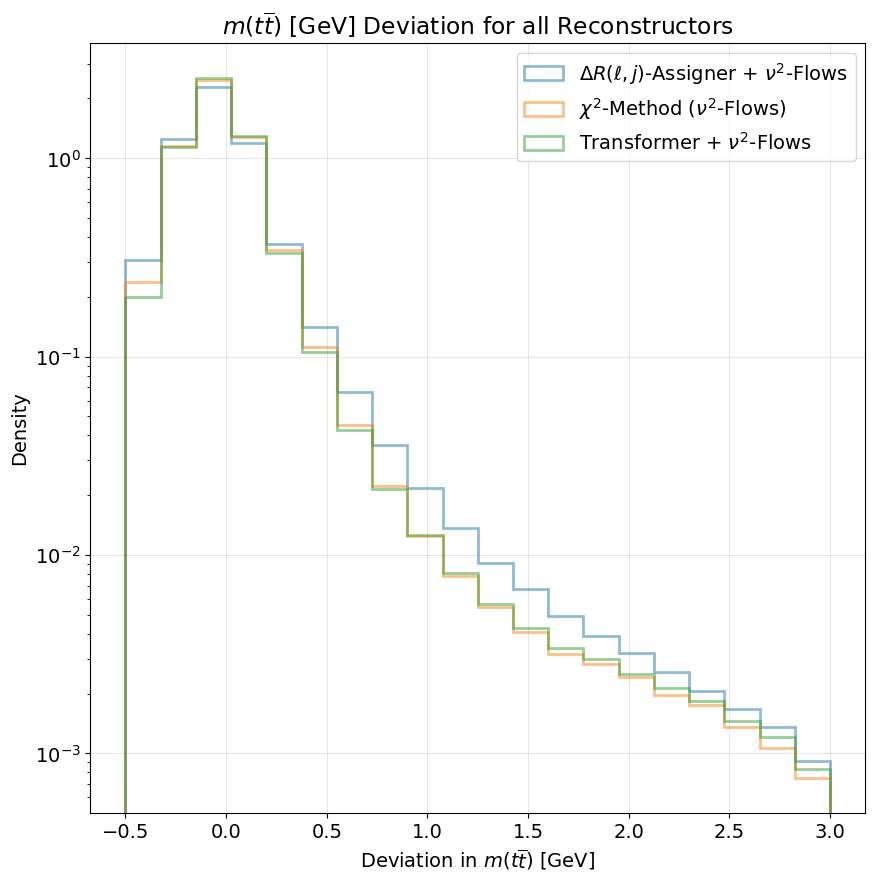

In [ ]:
fig, ax = evaluator.plot_ttbar_mass_deviation_distribution(bins = 20, xlims = (-0.5, 3))
ax.set_yscale("log")
fig.savefig(f"{PLOTS_DIR}/ttbar_mass_deviation_distribution.png", bbox_inches="tight")

/Users/simi/mva-trainer/notebooks/../core/evaluation/physics_calculations.py:226: RuntimeWarning: invalid value encountered in multiply
  v_par_coeff = np.sum(vv * n, axis=1)[:, None]   # scalar (N,1)
/Users/simi/mva-trainer/notebooks/../core/evaluation/physics_calculations.py:231: RuntimeWarning: invalid value encountered in multiply
  v_par_prime = gamma[:, None] * (v_par + beta * E[:, None] * n)


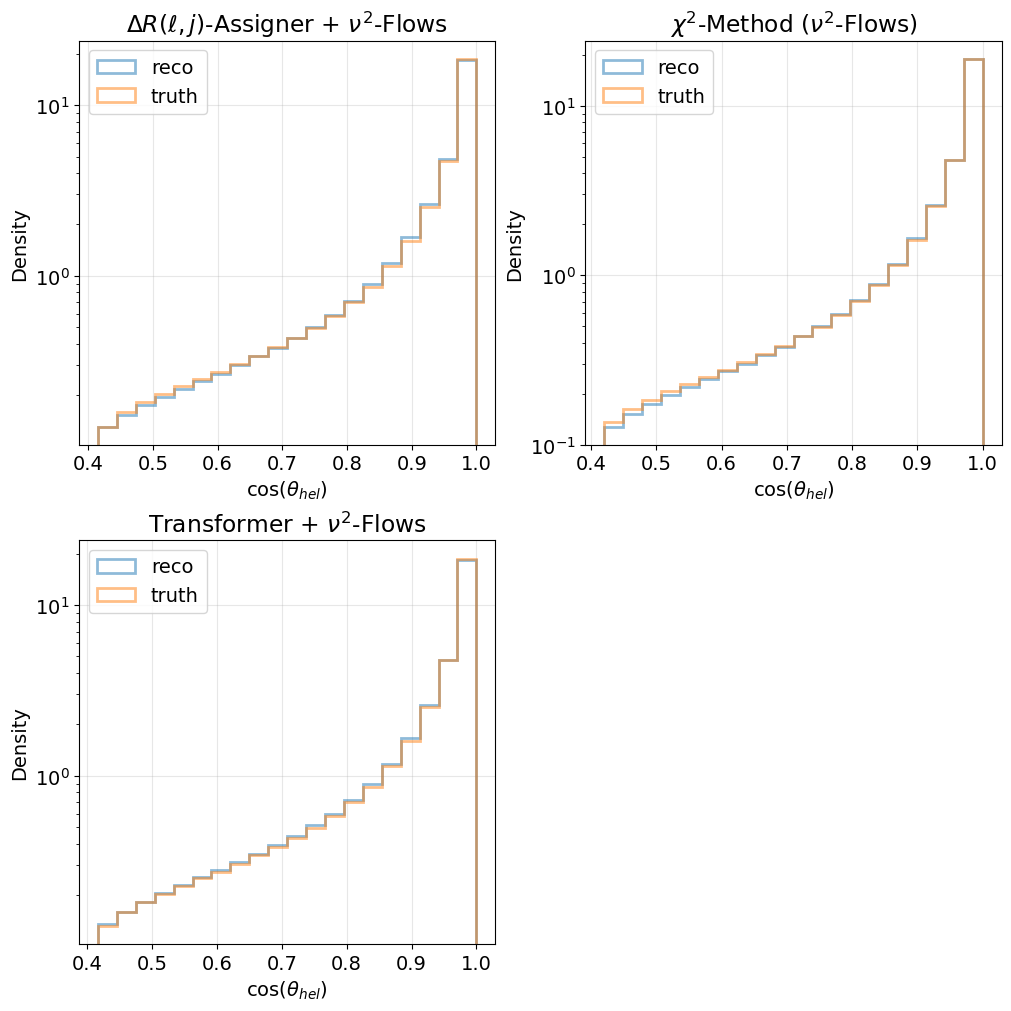

In [ ]:
fig, axes = evaluator.plot_c_hel_distributions(bins = 20)
for ax in axes:
    ax.set_yscale("log")
fig.savefig(f"{PLOTS_DIR}/c_hel_distributions.png", bbox_inches="tight")

/Users/simi/mva-trainer/notebooks/../core/evaluation/physics_calculations.py:226: RuntimeWarning: invalid value encountered in multiply
  v_par_coeff = np.sum(vv * n, axis=1)[:, None]   # scalar (N,1)
/Users/simi/mva-trainer/notebooks/../core/evaluation/physics_calculations.py:231: RuntimeWarning: invalid value encountered in multiply
  v_par_prime = gamma[:, None] * (v_par + beta * E[:, None] * n)


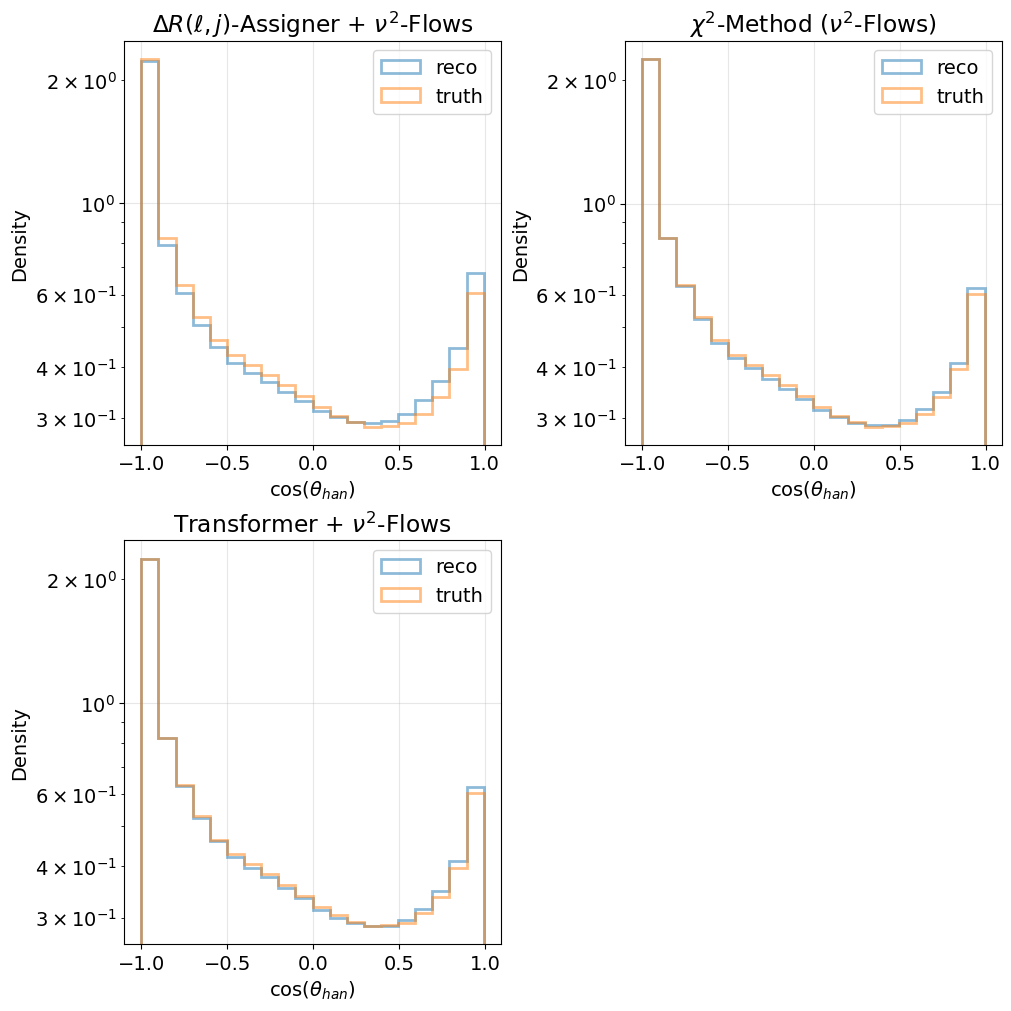

In [ ]:
fig, axes = evaluator.plot_c_han_distributions(bins = 20)
for ax in axes:
    ax.set_yscale("log")
fig.savefig(f"{PLOTS_DIR}/c_han_distributions.png", bbox_inches="tight")

## Resolution Plots


Computing binned $\cos(\theta_{hel})$ Resolution for truth_ttbar_mass...


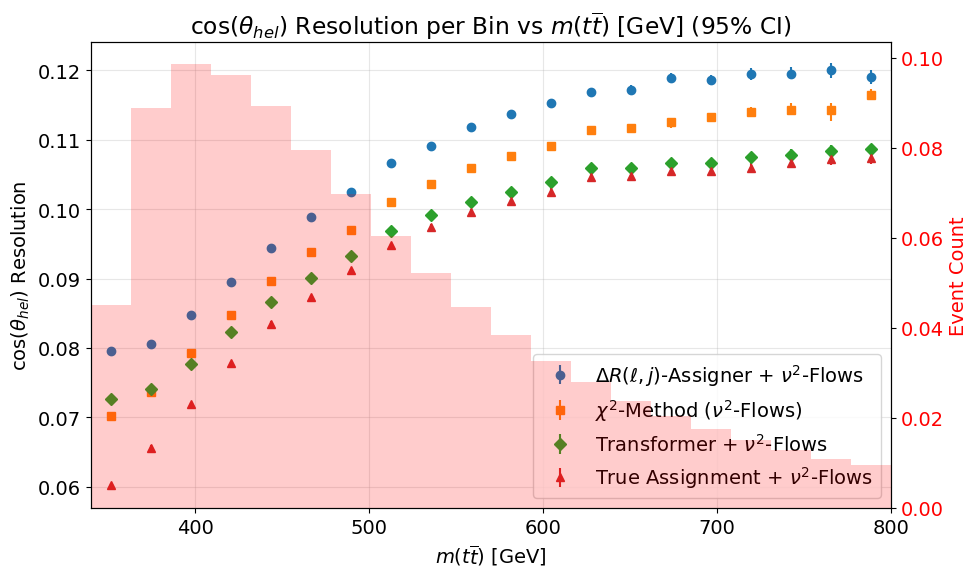

In [ ]:
fig, ax = evaluator.plot_binned_c_hel_resolution(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    n_bootstrap=10,
    xlims=(340e3, 800e3),
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "c_hel_resolution_comparison.pdf")


Computing binned $\cos(\theta_{han})$ Resolution for truth_ttbar_mass...


/Users/simi/mva-trainer/notebooks/../core/evaluation/physics_calculations.py:226: RuntimeWarning: invalid value encountered in multiply
  v_par_coeff = np.sum(vv * n, axis=1)[:, None]   # scalar (N,1)
/Users/simi/mva-trainer/notebooks/../core/evaluation/physics_calculations.py:231: RuntimeWarning: invalid value encountered in multiply
  v_par_prime = gamma[:, None] * (v_par + beta * E[:, None] * n)


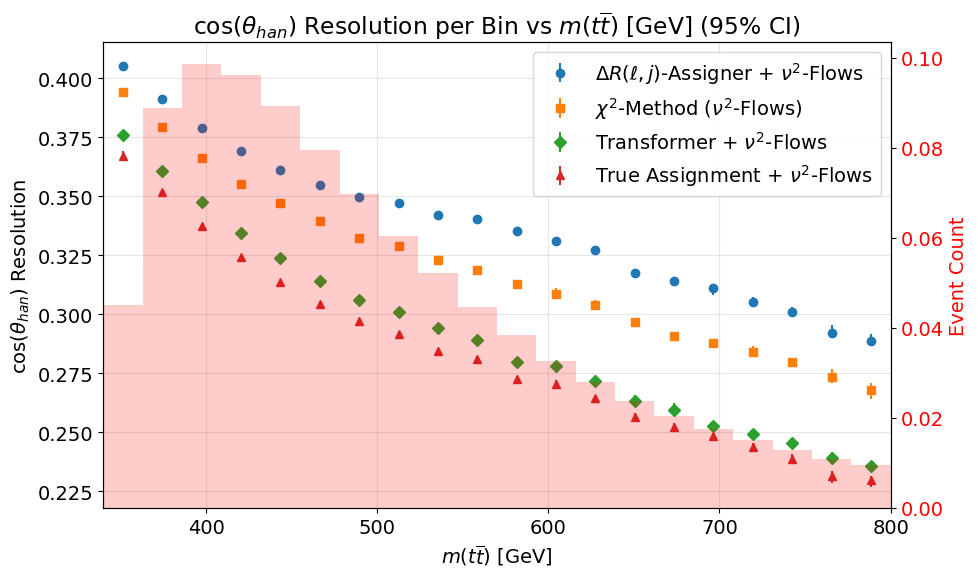

In [ ]:
fig, ax = evaluator.plot_binned_c_han_resolution(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    n_bootstrap=10,
    xlims=(340e3, 800e3),
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "c_han_resolution_comparison.pdf")


Computing binned Relative $m(t\overline{t})$ Resolution for truth_ttbar_mass...


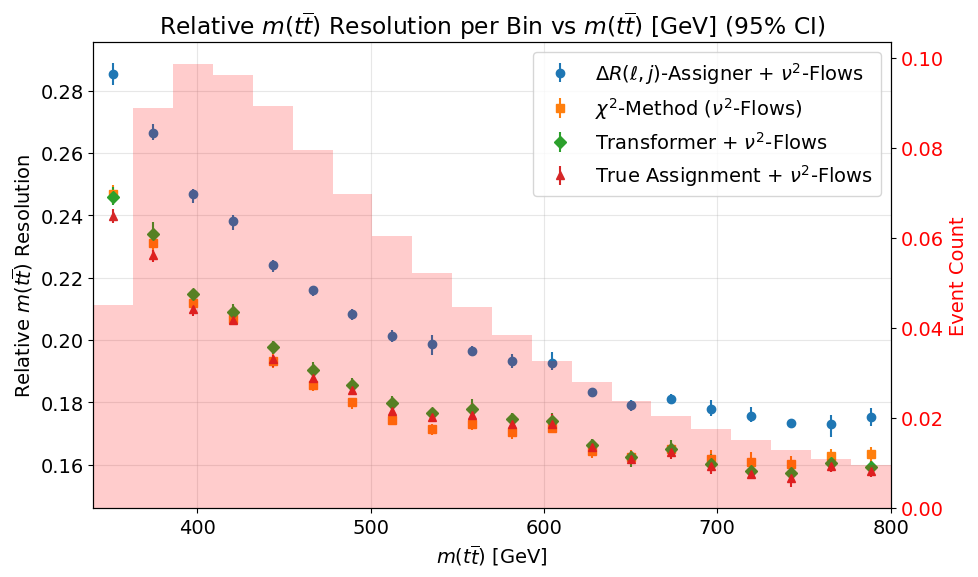

In [ ]:
fig, ax = evaluator.plot_binned_ttbar_mass_resolution(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    n_bootstrap=10,
    xlims=(340e3, 800e3),
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "ttbar_mass_resolution_comparison.pdf")


Computing bootstrap confidence intervals...
$\Delta R(\ell,j)$-Assigner + $\nu^2$-Flows: 0.4758 [0.4755, 0.4762]
$\chi^2$-Method ($\nu^2$-Flows): 0.6094 [0.6091, 0.6095]
Transformer + $\nu^2$-Flows: 0.7940 [0.7937, 0.7943]
True Assignment + $\nu^2$-Flows: Ground Truth (skipping)


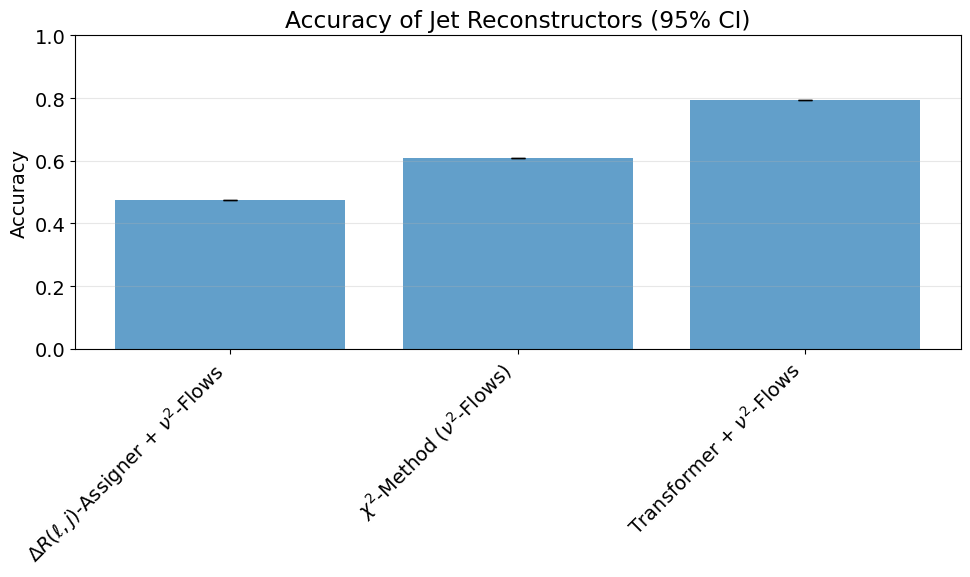

In [ ]:
fig, ax = evaluator.plot_all_accuracies(
    n_bootstrap=10
)
fig.savefig(PLOTS_DIR + "all_accuracies.pdf")

## Accuracy Plots


Computing binned accuracy for N_jets...


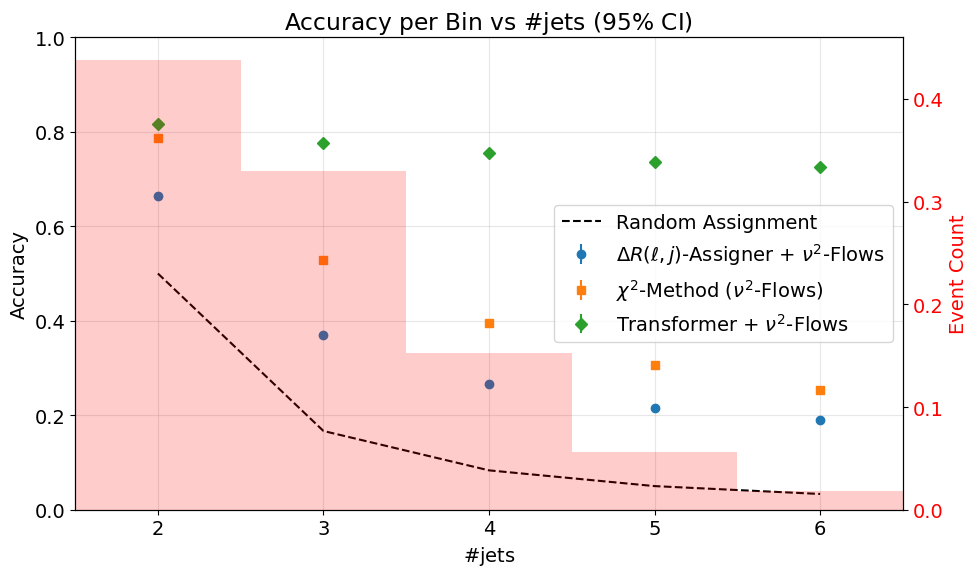

In [ ]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="N_jets",
    fancy_feature_label=r"$\# \text{jets}$",
    xlims=(2, data_configs["LoadConfig"]["max_jets"] + 1),
    bins=data_configs["LoadConfig"]["max_jets"] - 1,
    n_bootstrap=10,
)
ax.set_xticks([i + 0.5 for i in range(2, data_configs["LoadConfig"]["max_jets"] + 1)])
ax.set_xticklabels([i for i in range(2, data_configs["LoadConfig"]["max_jets"] + 1)])
fig.savefig(PLOTS_DIR + "binned_accuracy_N_jets.pdf")


Computing binned accuracy for truth_ttbar_mass...


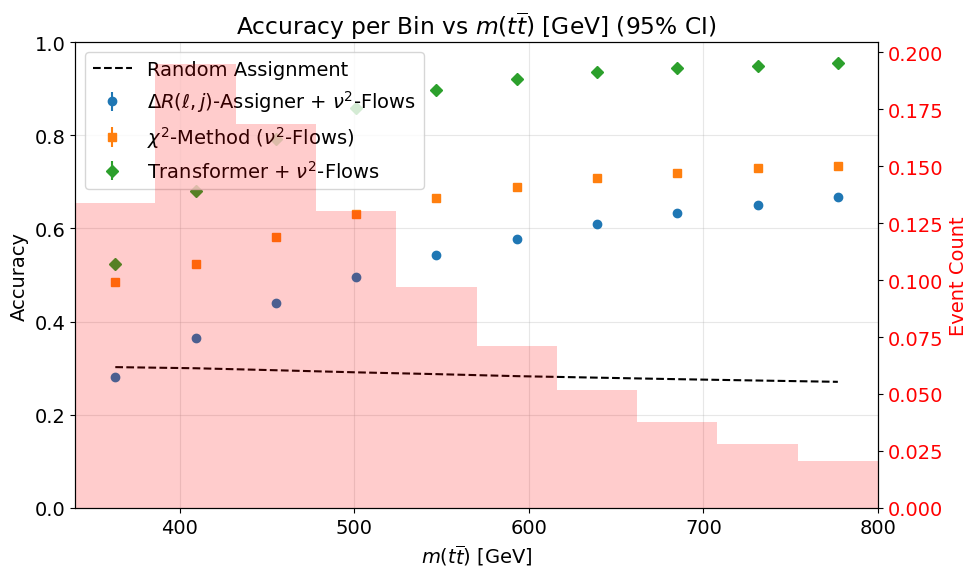

In [ ]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
    bins=10,
    n_bootstrap=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "binned_accuracy_ttbar_mass.pdf")


Computing binned accuracy for truth_ttbar_pt...


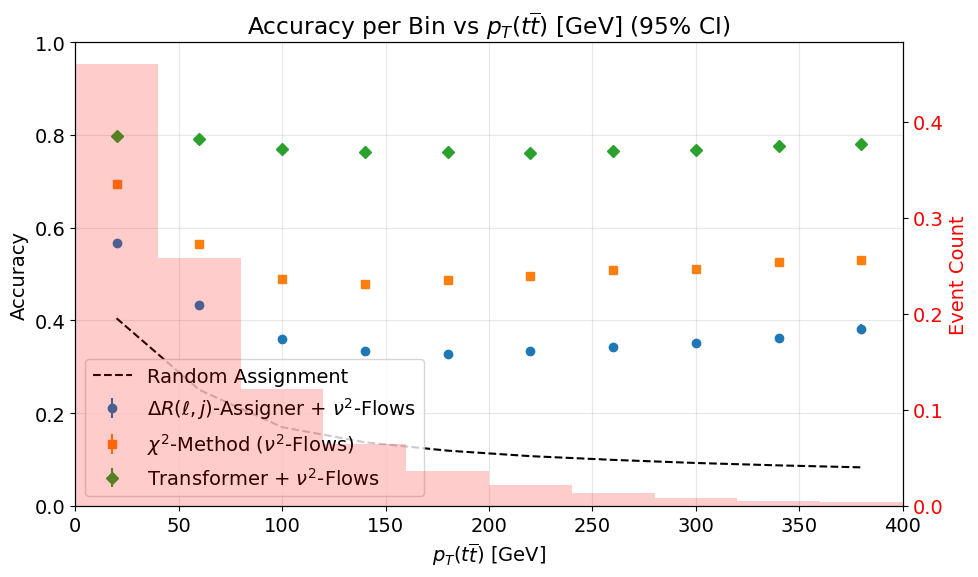

In [ ]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="truth_ttbar_pt",
    fancy_feature_label=r"$p_T(t\overline{t})$ [GeV]",
    xlims=(0, 400e3),
    bins=10,
    n_bootstrap=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(0, 400e3)

fig.savefig(PLOTS_DIR + "binned_accuracy_ttbar_pT.pdf")


Computing binned Relative $m(t)$ Resolution for truth_ttbar_mass...


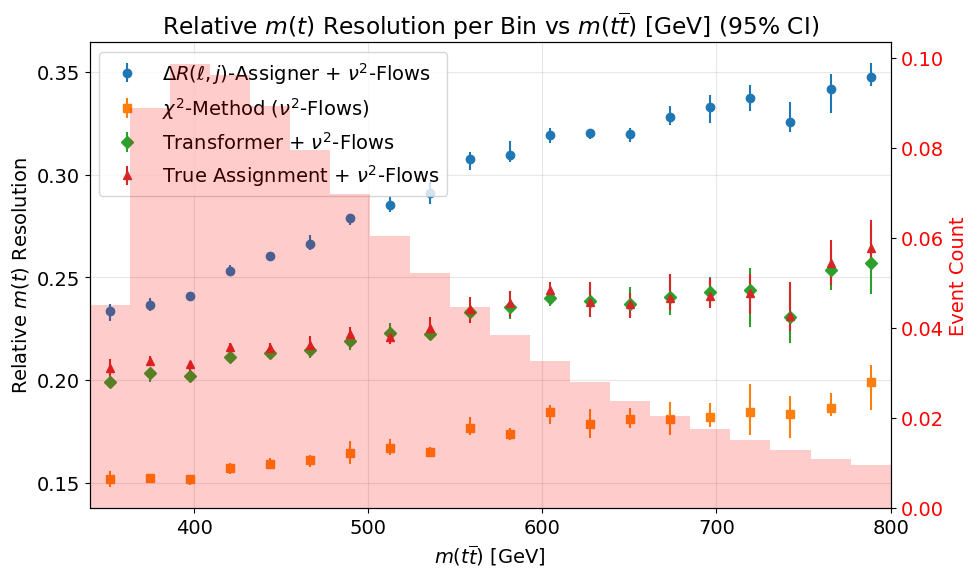

In [ ]:
fig, ax = evaluator.plot_binned_top_mass_resolution(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
    n_bootstrap=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "top_mass_resolution_comparison.pdf")

## Mass Resolution and Deviation Plots


Computing binned Mean Relative $m(t)$ Deviation for truth_ttbar_mass...


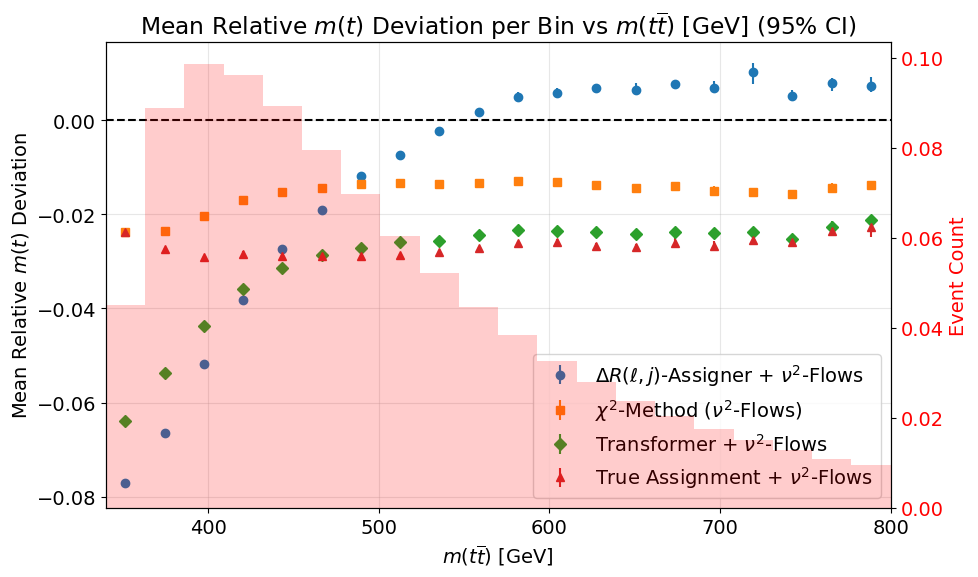

In [ ]:
fig, ax = evaluator.plot_binned_top_mass_deviation(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
    n_bootstrap=10,
)
ticks = ax.get_xticks()
ax.axhline(0, color="black", linestyle="--")
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "top_mass_deviation_comparison.pdf")


Computing binned Mean Relative $m(t\overline{t})$ Deviation for truth_ttbar_mass...


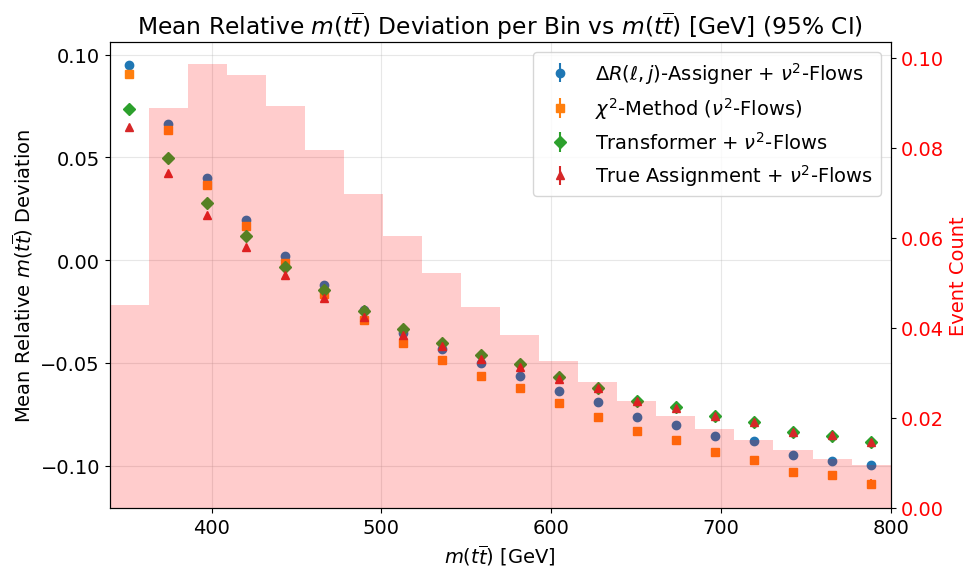

In [ ]:
fig, ax = evaluator.plot_binned_ttbar_mass_deviation(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    n_bootstrap=10,
    xlims=(340e3, 800e3),
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "ttbar_mass_deviation_comparison.pdf")


Computing binned accuracy for truth_ttbar_mass...


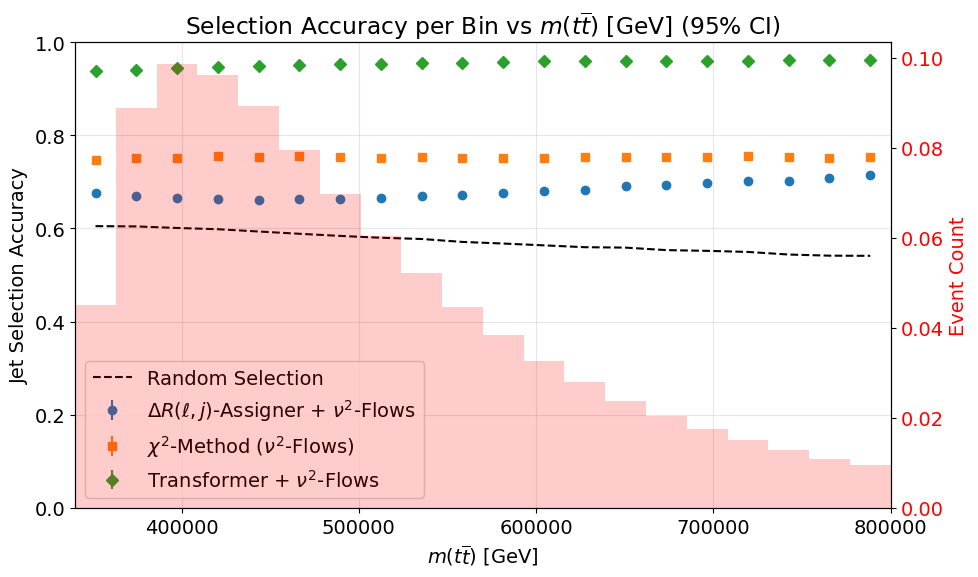

In [ ]:
evaluator.plot_binned_selection_accuracy(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    n_bootstrap=10,
    xlims=(340e3, 800e3),
)
fig.savefig(PLOTS_DIR + "binned_selection_accuracy_ttbar_mass.pdf")

## Confusion Matrices and Complementarity


Computing binned accuracy for truth_initial_parton_num_gluons...


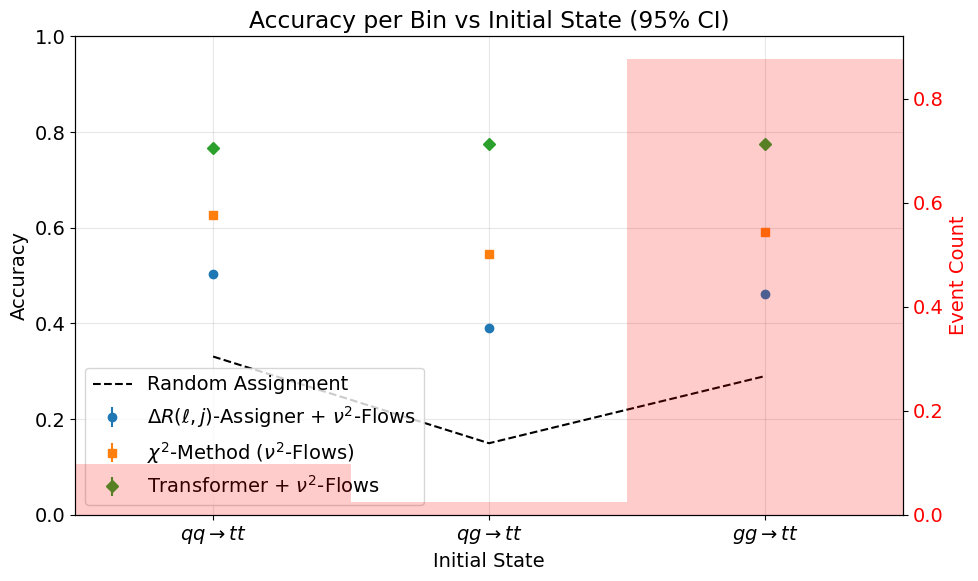

In [ ]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="truth_initial_parton_num_gluons",
    fancy_feature_label=r"Initial State",
    xlims=(0, 3),
    bins=3,
    n_bootstrap=10,
)
ax.set_xticks([0.5, 1.5, 2.5])
ax.set_xticklabels([r"$qq\to tt$", r"$qg\to tt$", r"$gg\to tt$"])
fig.savefig(PLOTS_DIR + "binned_accuracy_initial_state.pdf")

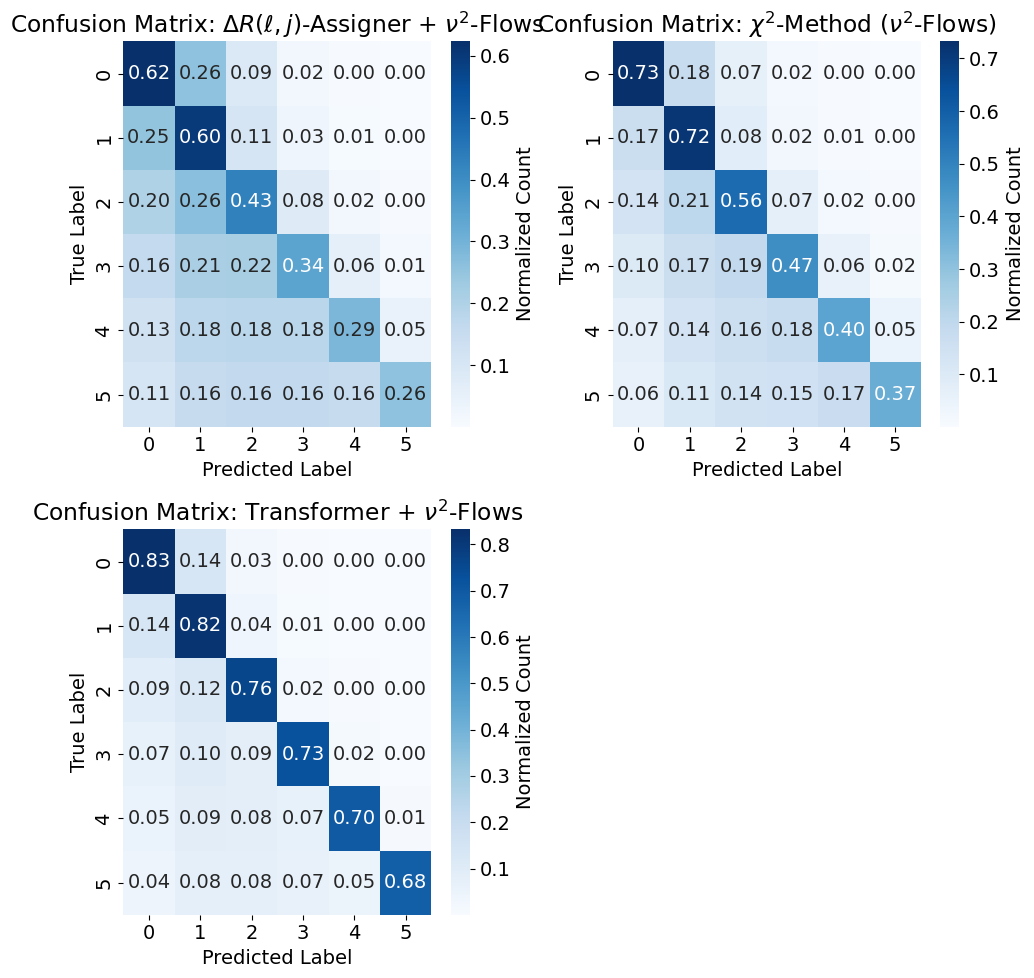

In [ ]:
fig, ax = evaluator.plot_confusion_matrices()
fig.savefig(PLOTS_DIR + "confusion_matrices.pdf")

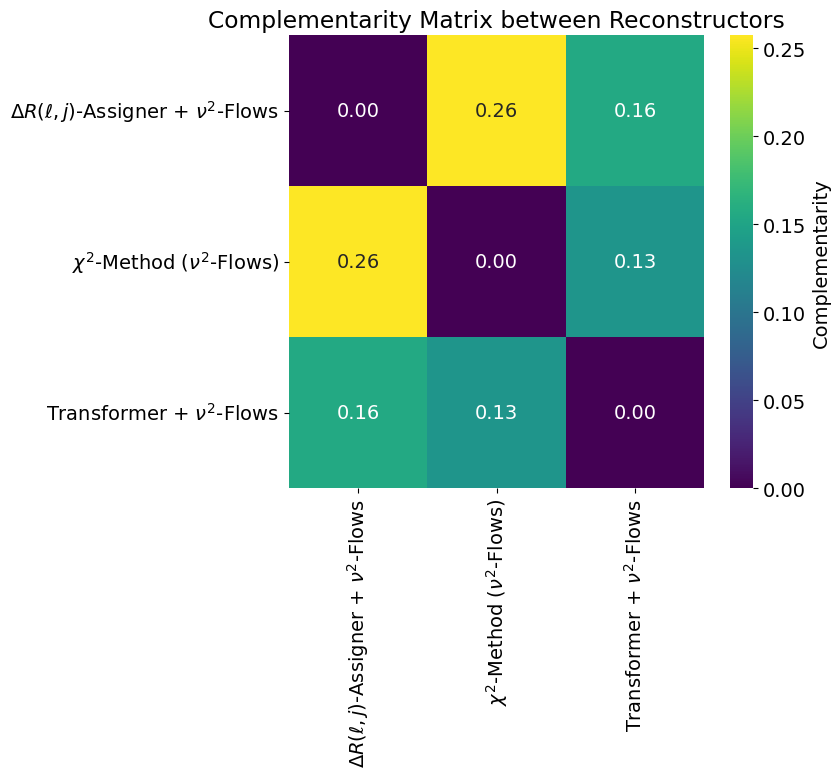

In [ ]:
fig, ax = evaluator.plot_complementarity_matrix(figsize=(8.5, 8))
fig.savefig(PLOTS_DIR + "complementarity_matrix.pdf")